In [1]:
import yfinance as yf
import pandas as pd
from tqdm import tqdm
from typing import Literal
import time, random
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.api import OLS, add_constant
from statsmodels.tsa.stattools import grangercausalitytests, adfuller

#### Utiliser pour avoir une vision globale de l'évolution des beta sur l'index, prend beaucoup de temps à tourner

rolling_beta = pd.DataFrame()
for ticker in history_df:
    rolling_beta[ticker] = history_df[ticker].rolling(window=150).apply(lambda x: beta(x, market_df), raw=False)

In [99]:
start_period = '01/01/2004'
end_period = '01/01/2024'

market_ticker = '^FCHI'
index_df = pd.read_csv('index_composition.csv', index_col = 'Ticker')
sector_list = index_df['Sector']

range_dict = {
    '1M' : 1,
    '3M' : 75
}

way_dict = {
    'Up' : '+'
}
range_beta = 150

In [108]:
def max_drawdown(history: pd.Series) -> float:
    """
    #### Description:
    Max Drawdown is a measure of the largest loss from a peak to a trough in a financial instrument's historical performance.
    It is calculated as the percentage decline relative to the highest cumulative value.

    #### Parameters:
    - history (pd.Series): Time series data representing the historical prices or returns of the financial instrument.

    #### Returns:
    - float: Maximum drawdown, representing the largest percentage decline from a peak to a trough.
    """
    # Calculate the cumulative percentage change in price or returns
    index = 100 * (1 + history.pct_change()).cumprod()

    # Identify the peaks and calculate drawdowns
    peaks = index.cummax()
    drawdowns = (index - peaks) / peaks

    # Return the maximum drawdown
    return drawdowns.min()

def beta(asset: pd.Series, market: pd.Series, way: Literal['+', '-', 'all']):
    """
    #### Description:
    Beta is a measure of a financial instrument's sensitivity to market movements. A beta of 1 indicates the asset tends
    to move in line with the market, a beta greater than 1 suggests higher volatility, and a beta less than 1 indicates
    lower volatility compared to the market.

    #### Parameters:
    - asset (pd.Series): Time series data representing the returns of the asset.
    - market (pd.Series): Time series data representing the returns of the market.
    - way (Literal['+', '-', 'all']): Specifies which type of data points should be considered for the beta calculation:
        - '+' (positive): Only considers periods where the asset's returns are positive. This is useful for measuring
          the beta when the asset is performing well.
        - '-' (negative): Only considers periods where the asset's returns are negative. This is useful for measuring
          the beta when the asset is underperforming.
        - 'all': Considers all periods without any filtering, giving the traditional beta measurement.

    #### Returns:
    - float: Beta coefficient, which measures the asset's sensitivity to market movements based on the specified filter.
    """
    # Combine asset and market returns, calculate covariance and market variance
    df = pd.concat([asset, market], axis=1).dropna().pct_change().dropna()

    # Filter data based on the 'way' parameter, focusing on asset variations
    if way == '+':
        df = df[df.iloc[:, 0] > 0]  # Filter where asset returns are positive
    elif way == '-':
        df = df[df.iloc[:, 0] < 0]  # Filter where asset returns are negative
    elif way == 'all':
        pass  # No filtering needed

    # Calculate covariance and market variance
    covariance = df.cov().iloc[1, 0]
    market_variance = df.iloc[:, 1].var()

    # Calculate beta as the ratio of covariance to market variance
    return covariance / market_variance


In [89]:
# Fetching market_df data and risk-free rate
market_df = (
    yf.Ticker(market_ticker)
    .history('max')['Close']
    .rename(market_ticker)
    .resample('B').last()
    .ffill()
    .tz_localize(None)
)

# Fetching and reating a DataFrame to store historical prices for each asset
history_df = pd.DataFrame()
for ticker in tqdm(index_df.index):
    history = yf.Ticker(ticker).history('max')
    history_df[ticker] = history['Close']
    time.sleep(random.uniform(0, 0.1))
history_df = history_df.resample('B').last().ffill()
history_df = history_df.tz_localize(None)
history_df = history_df.dropna(axis=1, how='all')

100%|██████████| 40/40 [00:15<00:00,  2.58it/s]


In [100]:
independent_df = pd.DataFrame()
for date in tqdm(history_df[start_period:end_period].resample('W-FRI').last().index):
    history = history_df.loc[:date].dropna(axis=1)

    results = pd.DataFrame()
    for way_keys, way_values in way_dict.items():

        for range_keys, range_values in range_dict.items():

            for ticker in history:
                asset = history[ticker].iloc[-range_beta-range_values:-range_values]
                market = market_df.loc[:date].iloc[-range_beta-range_values:-range_values]

                results.at[ticker, f'{way_keys} - {range_keys}'] = beta(
                    asset   = asset, 
                    market  = market, 
                    way     = way_values
                )

    results = pd.concat([results, sector_list], axis=1)
    results = results.groupby(sector_list.name).mean()

    independent_df[date] = results['Up - 1M'] - results['Up - 3M'] #à revoir pour plus de flexibilité

independent_df = independent_df.T

100%|██████████| 1045/1045 [04:13<00:00,  4.12it/s]


In [123]:
dependent_df = market_df.resample('W-FRI').last()
dependent_df = dependent_df.rolling(150).apply(lambda x: max_drawdown(x))
dependent_df = dependent_df[start_period:end_period]

In [124]:
df = pd.concat([independent_df, dependent_df], axis=1)
df = add_constant(df)
independent = independent_df.columns.to_list() + ['const']
dependent = market_ticker

In [114]:
df.describe().round(3)

,const,Basic Materials,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Real Estate,Technology,Telecommunications,Utilities,^FCHI
count,1044.0,1044.000,1044.000,1044.000,1044.000,1044.000,1044.000,1044.000,0.0,1044.000,1044.000,1044.000,1044.000
mean,1.0,0.001,0.005,-0.003,-0.005,-0.006,0.002,0.001,NaN,-0.007,-0.008,-0.014,-0.294
std,0.0,0.164,0.132,0.109,0.184,0.273,0.111,0.122,NaN,0.161,0.163,0.274,0.140
min,1.0,-0.442,-0.377,-0.363,-0.932,-0.912,-0.292,-0.438,NaN,-0.611,-0.649,-1.417,-0.589
25%,1.0,-0.107,-0.089,-0.065,-0.093,-0.148,-0.072,-0.063,NaN,-0.083,-0.099,-0.124,-0.336
50%,1.0,0.004,-0.000,-0.006,-0.007,0.004,0.002,-0.007,NaN,0.009,0.004,-0.014,-0.274
75%,1.0,0.098,0.079,0.063,0.068,0.116,0.070,0.053,NaN,0.076,0.097,0.092,-0.179
max,1.0,0.751,0.420,0.332,0.768,1.051,0.411,0.723,NaN,0.581,0.522,1.549,-0.086


<Axes: >

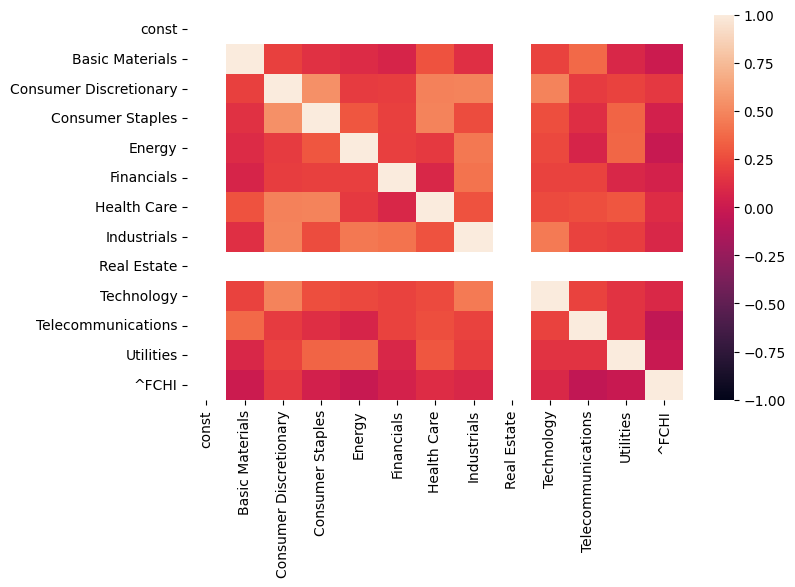

In [115]:
plt.gcf().set_size_inches(8, 5)
sns.heatmap(df[start_period:end_period].corr(), vmin=-1, vmax=1, annot=False)

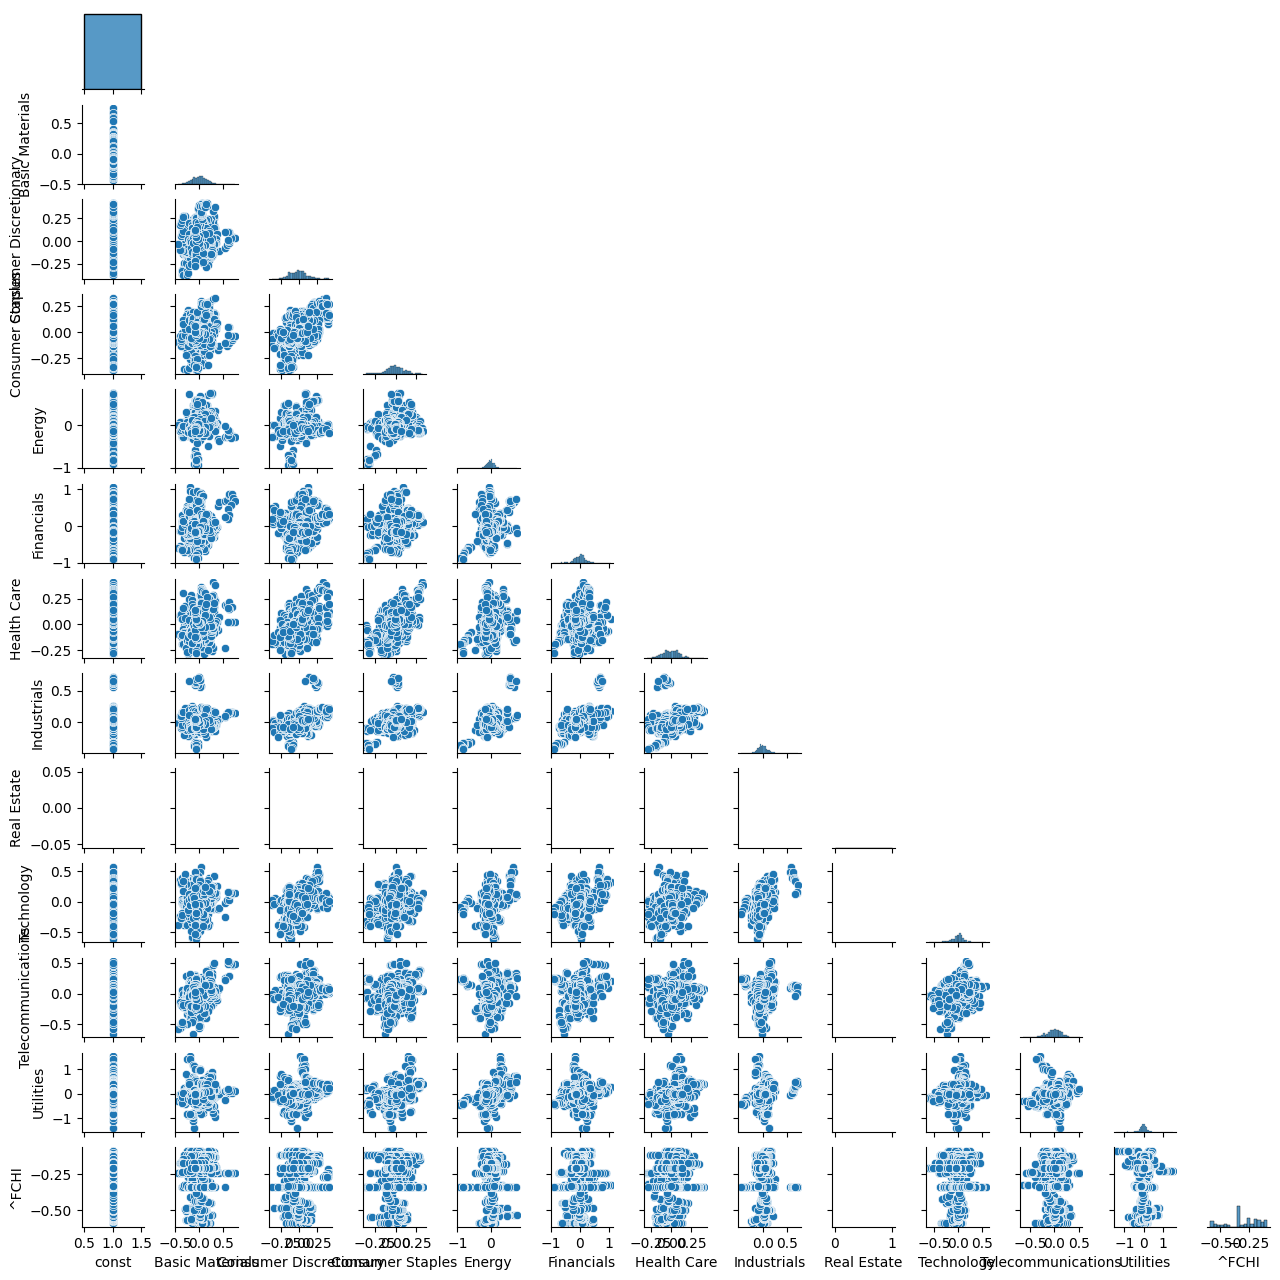

In [116]:
sns.pairplot(df, height=1, corner=True)

In [117]:
df[independent]

,Basic Materials,Consumer Discretionary,Consumer Staples,Energy,Financials,Health Care,Industrials,Real Estate,Technology,Telecommunications,Utilities,const
2004-01-02,0.080617,-0.222323,-0.299372,0.068953,-0.246175,-0.193292,-0.058006,NaN,0.030420,-0.104686,-0.774748,1.0
2004-01-09,0.069356,-0.212719,-0.313152,0.056427,-0.253690,-0.189446,-0.092789,NaN,0.057357,-0.087383,-0.700243,1.0
2004-01-16,0.045360,-0.185039,-0.291172,0.052232,-0.250676,-0.143972,-0.088687,NaN,0.043479,-0.171503,-0.819302,1.0
2004-01-23,0.121404,-0.103281,-0.198979,0.064037,-0.085645,-0.061369,-0.037510,NaN,0.053951,0.081811,-0.490870,1.0
2004-01-30,0.124840,-0.023037,-0.174746,0.058483,-0.096124,-0.097189,-0.033592,NaN,-0.015658,0.083767,-0.451241,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-01,-0.060276,0.046479,0.002669,-0.037249,-0.168598,0.041102,0.017005,NaN,-0.189172,-0.094330,0.021681,1.0
2023-12-08,-0.068182,0.042124,-0.003836,-0.063724,-0.167612,0.050203,0.029095,NaN,-0.192413,-0.089277,0.004640,1.0
2023-12-15,-0.100323,0.087836,0.002369,-0.057321,-0.174569,0.114175,0.017737,NaN,-0.049599,-0.034653,-0.010338,1.0
2023-12-22,-0.086847,0.113476,0.004345,-0.079034,-0.121816,0.125258,0.029819,NaN,-0.039825,-0.028785,-0.028582,1.0


In [118]:
mod = OLS(df[dependent], df[independent].dropna(axis=1))
model = mod.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  ^FCHI   R-squared:                       0.049
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     5.367
Date:                Mon, 28 Oct 2024   Prob (F-statistic):           9.13e-08
Time:                        08:44:49   Log-Likelihood:                 597.45
No. Observations:                1044   AIC:                            -1173.
Df Residuals:                    1033   BIC:                            -1118.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Basic Materials           -0